In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [58]:
import os
import tensorflow as tf
import numpy as np
import librosa
import librosa.display
from pydub import AudioSegment
import io
import tensorflow as tf
from tensorflow.keras import layers, models, metrics
import matplotlib.pyplot as plt

In [59]:
!pip install pydub

In [60]:
def load_audio_files(directory):
    audio_files = []
    for filename in os.listdir(directory):
        if filename.endswith(".wav"):  # Assuming audio files are in .wav format
            file_path = os.path.join(directory, filename)
            file_contents = tf.io.read_file(file_path)
            audio_files.append(file_contents)
    return audio_files

# Directory paths for fake and real audio files
fake_directory = "/content/drive/MyDrive/data/fake"
real_directory = "/content/drive/MyDrive/data/real"

# Load fake and real audio files
fake_audio = load_audio_files(fake_directory)
real_audio = load_audio_files(real_directory)

# Print the number of fake and real audio files loaded
print("Number of fake audio files loaded:", len(fake_audio))
print("Number of real audio files loaded:", len(real_audio))


Number of fake audio files loaded: 500
Number of real audio files loaded: 500


In [61]:
def preprocess_audio(audio_files, sample_rate=22050, duration=4, n_fft=2048, hop_length=512, n_mels=128):
    processed_audio = []
    for audio in audio_files:
        # Decode audio file
        audio = tf.audio.decode_wav(audio)
        audio = audio.audio[:, 0]  # Extract the first channel if stereo
        audio = tf.cast(audio, tf.float32)  # Convert audio to float32
        audio_numpy = audio.numpy()  # Convert to NumPy array
        # Convert audio to raw bytes
        raw_audio = tf.audio.encode_wav(tf.reshape(audio, [-1, 1]), sample_rate)
        # Resample audio if needed using pydub
        audio_segment = AudioSegment.from_wav(io.BytesIO(raw_audio.numpy()))
        if len(audio_segment) != duration * 1000:  # Duration is in seconds, so multiply by 1000 to convert to milliseconds
            audio_segment = audio_segment.set_frame_rate(sample_rate).set_channels(1).set_sample_width(2)
            audio_segment = audio_segment.set_frame_rate(sample_rate)
        # Export resampled audio as raw bytes
        with io.BytesIO() as output:
            audio_segment.export(output, format="wav")
            output.seek(0)
            resampled_audio = output.read()
        # Convert audio to spectrogram
        spectrogram = librosa.feature.melspectrogram(y=audio_numpy, sr=sample_rate, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels)
        spectrogram = librosa.power_to_db(spectrogram, ref=np.max)
        processed_audio.append(spectrogram)
    return processed_audio

# Preprocess fake and real audio
fake_spectrograms = preprocess_audio(fake_audio)
real_spectrograms = preprocess_audio(real_audio)

# Print the shapes of preprocessed data
print("Shape of fake audio spectrograms:", fake_spectrograms[0].shape)
print("Shape of real audio spectrograms:", real_spectrograms[0].shape)

Shape of fake audio spectrograms: (128, 365)
Shape of real audio spectrograms: (128, 465)


In [64]:
import matplotlib.pyplot as plt
import librosa.display

# Load one real and one fake audio file
real_audio_file_path = "/content/drive/MyDrive/data/fake/africanm (1).wav"
fake_audio_file_path = "/content/drive/MyDrive/data/real/africanm (18).wav"

real_audio, sr = librosa.load(real_audio_file_path)
fake_audio, _ = librosa.load(fake_audio_file_path, sr=sr)

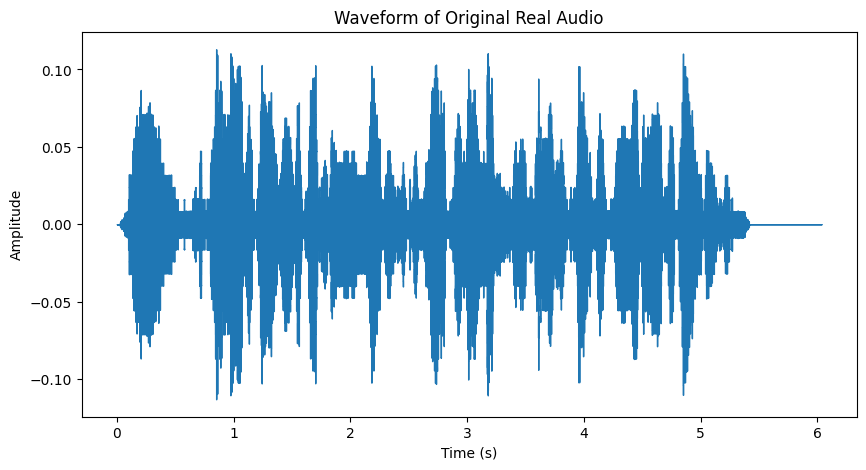

In [65]:
# Plot the waveform of the original real audio
plt.figure(figsize=(10, 5))
librosa.display.waveshow(real_audio, sr=sr)
plt.title('Waveform of Original Real Audio')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.show()

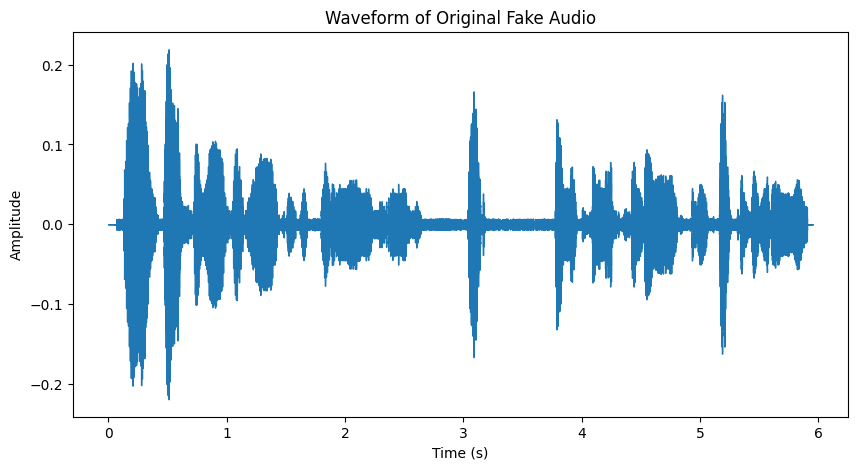

In [66]:
# Plot the waveform of the original fake audio
plt.figure(figsize=(10, 5))
librosa.display.waveshow(fake_audio, sr=sr)
plt.title('Waveform of Original Fake Audio')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.show()

In [39]:
from skimage.transform import resize

# Resize all spectrograms to a common shape
target_shape = (128, 128)  # Define the target shape
fake_spectrograms_resized = [resize(spec, target_shape, mode='constant', anti_aliasing=True) for spec in fake_spectrograms]
real_spectrograms_resized = [resize(spec, target_shape, mode='constant', anti_aliasing=True) for spec in real_spectrograms]

# Concatenate resized spectrograms and create labels
X = np.array(fake_spectrograms_resized + real_spectrograms_resized)
y = np.array([0] * len(fake_spectrograms_resized) + [1] * len(real_spectrograms_resized))  # 0 for fake, 1 for real

# Shuffle the data
indices = np.arange(len(X))
np.random.shuffle(indices)
X = X[indices]
y = y[indices]

# Split the data into training and validation sets
split_idx = int(0.8 * len(X))
X_train, X_val = X[:split_idx], X[split_idx:]
y_train, y_val = y[:split_idx], y[split_idx:]

In [44]:
# Define metrics
precision = metrics.Precision()
recall = metrics.Recall()

# Define the CNN model
model = models.Sequential([
    layers.Input(shape=(128, 128, 1)),  # Input shape: (num_mels, time_frames, channels)
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(1, activation='sigmoid')  # Output layer with sigmoid activation for binary classification
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', precision, recall])

# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/10
25/25 [==============================] - 30s 1s/step - loss: 6.6298 - accuracy: 0.5288 - precision: 0.5345 - recall: 0.5173 - val_loss: 0.5476 - val_accuracy: 0.9700 - val_precision: 0.9592 - val_recall: 0.9792
Epoch 2/10
25/25 [==============================] - 28s 1s/step - loss: 0.3236 - accuracy: 0.8550 - precision: 0.8564 - recall: 0.8564 - val_loss: 0.1652 - val_accuracy: 0.9450 - val_precision: 1.0000 - val_recall: 0.8854
Epoch 3/10
25/25 [==============================] - 26s 1s/step - loss: 0.1120 - accuracy: 0.9663 - precision: 0.9748 - recall: 0.9579 - val_loss: 0.1228 - val_accuracy: 0.9750 - val_precision: 0.9505 - val_recall: 1.0000
Epoch 4/10
25/25 [==============================] - 28s 1s/step - loss: 0.0557 - accuracy: 0.9825 - precision: 0.9851 - recall: 0.9802 - val_loss: 0.0598 - val_accuracy: 0.9750 - val_precision: 0.9596 - val_recall: 0.9896
Epoch 5/10
25/25 [==============================] - 28s 1s/step - loss: 0.0610 - accuracy: 0.9787 - precision: 0

In [45]:
print("Training accuracy:", history.history['accuracy'][-1])
print("Validation accuracy:", history.history['val_accuracy'][-1])
print("Training precision:", history.history['precision'][-1])
print("Validation precision:", history.history['val_precision'][-1])
print("Training recall:", history.history['recall'][-1])
print("Validation recall:", history.history['val_recall'][-1])
print("Training loss:", history.history['loss'][-1])
print("Validation loss:", history.history['val_loss'][-1])

Training accuracy: 0.9925000071525574
Validation accuracy: 0.9649999737739563
Training precision: 0.9950248599052429
Validation precision: 0.9320388436317444
Training recall: 0.9900990128517151
Validation recall: 1.0
Training loss: 0.025290597230196
Validation loss: 0.1304207444190979


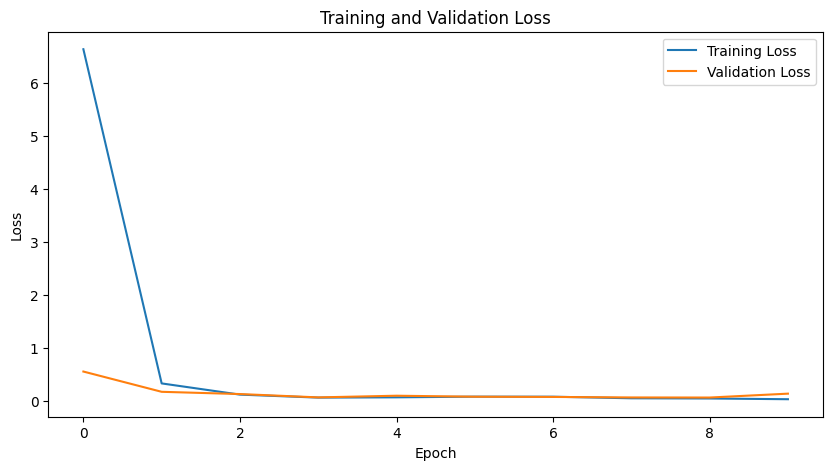

In [48]:
# Get training and validation loss
train_loss = history.history['loss']
val_loss = history.history['val_loss']
# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

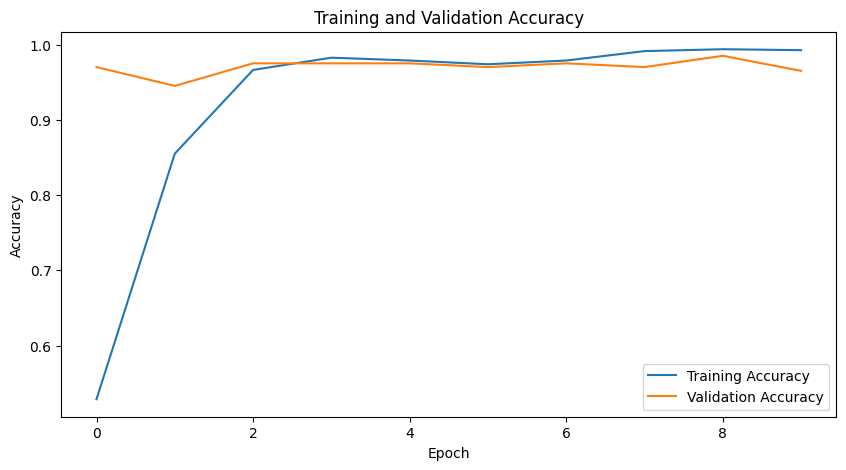

In [49]:
# Get training and validation accuracy
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
# Plot training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

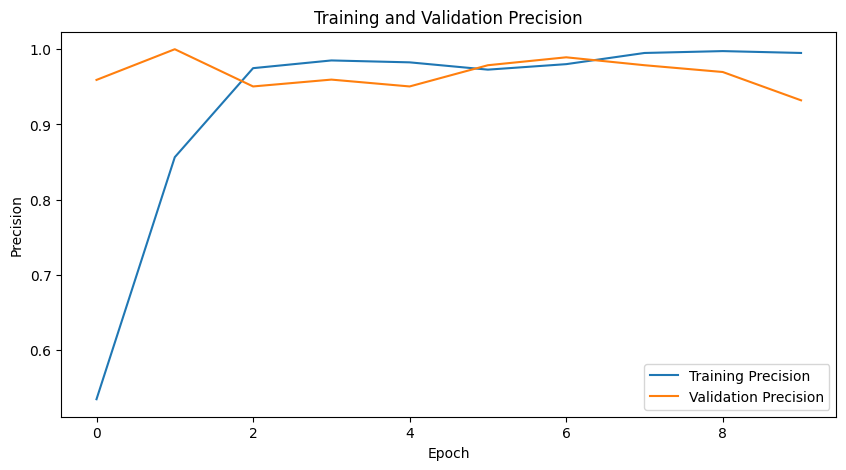

In [50]:
# Get training and validation precision
train_precision = history.history['precision']
val_precision = history.history['val_precision']
# Plot training and validation precision
plt.figure(figsize=(10, 5))
plt.plot(train_precision, label='Training Precision')
plt.plot(val_precision, label='Validation Precision')
plt.title('Training and Validation Precision')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.legend()
plt.show()

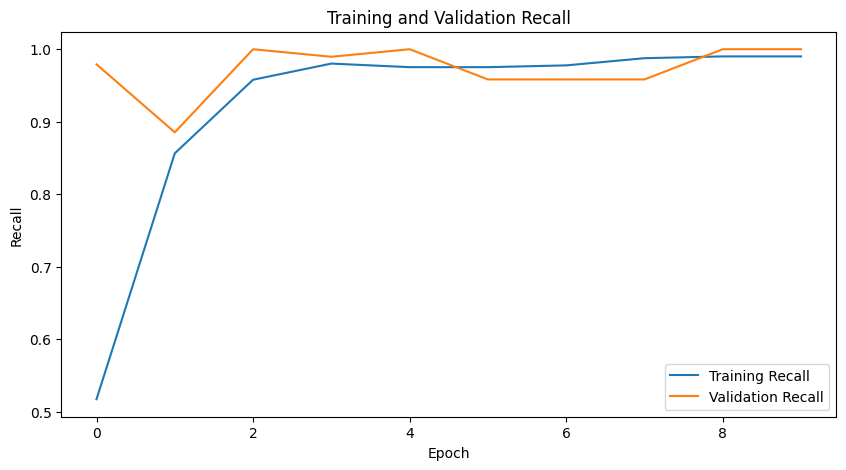

In [51]:
# Get training and validation recall
train_recall = history.history['recall']
val_recall = history.history['val_recall']
# Plot training and validation recall
plt.figure(figsize=(10, 5))
plt.plot(train_recall, label='Training Recall')
plt.plot(val_recall, label='Validation Recall')
plt.title('Training and Validation Recall')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.legend()
plt.show()